Ventilator Synchrony Scores

In [4]:
# Import Modules
import os 
from scipy.io import loadmat
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from openpyxl import load_workbook
from openpyxl import Workbook
import scipy
import re

In [9]:
# data_dir = 'C:/Users/sidha/OneDrive/Sid Stuff/PROJECTS/iMEDS Design Team/Data Analysis/PedAccel/data_analysis/PythonPipeline/PatientData'
data_dir = r'S:\Sedation_monitoring\PedAccel_directory\PedAccel\data_analysis\Misc_analysis\PatientData'
# data_dir = r'C:\Users\jakes\Documents\DT 6 Analysis\PythonCode\PedAccel\data_analysis\PythonPipeline\PatientData'
window_size = 100 #100 is 1 second worth of time
lead_time = 15
slice_size_min = 16
sr = .5

In [15]:
def load_from_excel(sbs_filepath, to_numpy=False, verbose=False):
    # Load data from Excel file
    df = pd.read_excel(sbs_filepath, header=0)
    col_names = df.columns.values.tolist()
    if to_numpy:
        array = df.to_numpy()
        return array, col_names
    return df, col_names

Processing Patient9
Loading Ventilator data
Skipping SBS score 0 at time 2024-01-15 23:37:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-16 18:54:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-16 19:45:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2024-01-16 19:49:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2024-01-18 04:18:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-18 10:44:00 due to zero mean respiratory rate
Skipping SBS score -1 at time 2024-01-18 20:57:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-19 13:38:00 due to zero mean respiratory rate
Skipping SBS score -1 at time 2024-01-19 15:43:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-19 15:47:00 due to zero mean respiratory rate
Skipping SBS score -1 at time 2024-01-19 19:55:00 due to zero mean respiratory rate
Skipping SBS score -1 at time 2024-

<Figure size 1000x600 with 0 Axes>

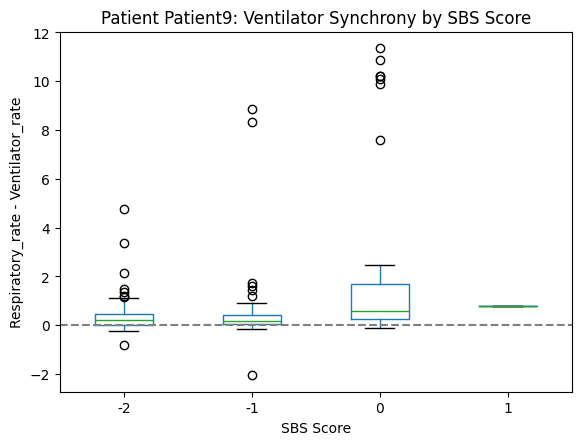

Sync data saved to: S:\Sedation_monitoring\PedAccel_directory\PedAccel\data_analysis\Misc_analysis\PatientData\Patient9\Patient9_sync_data.xlsx
Processing Patient4
Loading Ventilator data
Skipping SBS score -1 at time 2023-11-14 03:20:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2023-11-14 08:16:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-14 10:47:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-14 13:14:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-15 11:59:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-15 05:15:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-15 12:14:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2023-11-16 06:16:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2023-11-16 07:16:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2023-11-16 08:46:00 due to zer

<Figure size 1000x600 with 0 Axes>

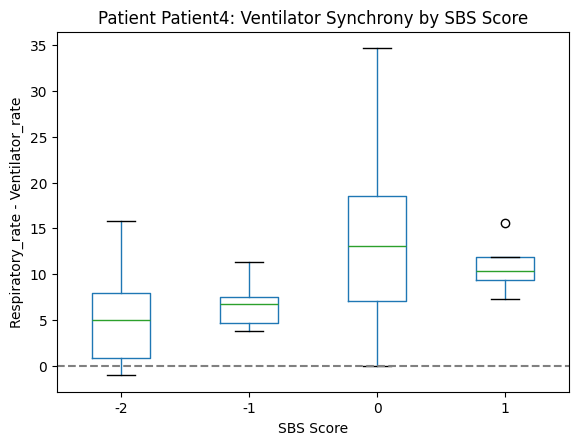

Sync data saved to: S:\Sedation_monitoring\PedAccel_directory\PedAccel\data_analysis\Misc_analysis\PatientData\Patient4\Patient4_sync_data.xlsx
Processing Patient11
Loading Ventilator data
Skipping SBS score -2 at time 2024-01-22 14:29:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-22 15:12:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 15:38:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 16:02:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2024-01-23 10:01:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2024-01-23 12:33:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-23 14:39:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 07:24:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 13:26:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 13:52:00 due to 

<Figure size 1000x600 with 0 Axes>

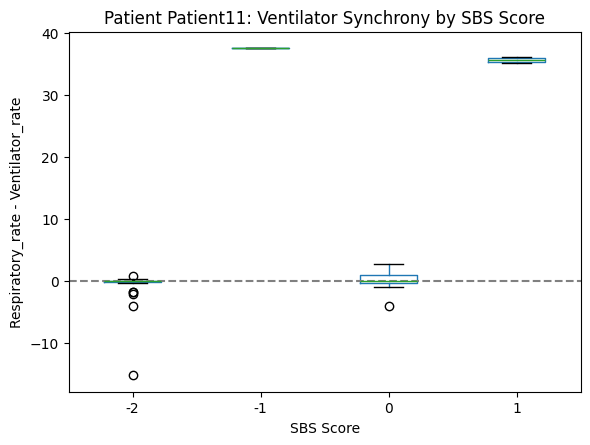

Sync data saved to: S:\Sedation_monitoring\PedAccel_directory\PedAccel\data_analysis\Misc_analysis\PatientData\Patient11\Patient11_sync_data.xlsx


In [37]:
for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        print(f'Processing {patient}')          
        data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_Retro.mat')
        
        data = loadmat(data_filepath)
        SBS = data['sbs'].flatten()
        rr = data['respiratory_rate']
        sbs_time = data['start_time']
        sbs_time = pd.to_datetime(sbs_time, errors='coerce')
        retro_PRN = data['PRNs'].flatten()
        # Remove all white spaces from each string
        retro_PRN = [s.replace(" ", "") for s in retro_PRN]
        
        ventilator_file = os.path.join(patient_dir, f'{patient}_ventilator_data.xlsx')
        print('Loading Ventilator data')

        if not os.path.isfile(ventilator_file):
            print("Ventilator File not found")
            continue 

        ventilator_data, vent_features = load_from_excel(ventilator_file)
        set_rate_data = ventilator_data[ventilator_data['meas_disp_name'] == 'Set Rate (bpm)'].copy()
        set_rate_data['assessment_datetime'] = pd.to_datetime(set_rate_data['assessment_datetime'], format='%Y-%m-%d %H:%M:%S')
        set_rate_data = set_rate_data.sort_values('assessment_datetime', ascending=True)
        
        # Calculate synchrony scores
        sync_data = []
        for i, (score, time) in enumerate(zip(SBS, sbs_time)):
            mean_rr = rr[i].mean()

            # Skip iteration if mean_rr = 0
            if mean_rr == 0:
                print(f"Skipping SBS score {score} at time {time} due to zero mean respiratory rate")
                continue
            
            # Initialize set_rate to None
            set_rate = None
            
            mask = set_rate_data['assessment_datetime'] <= time

            # Check if any rows match the condition
            if mask.any():
                # Get the most recent set rate
                set_rate = set_rate_data[mask]['question_response'].iloc[-1]
                # print(f"Set rate found: {set_rate}")

                set_rate_time = set_rate_data[mask]['assessment_datetime'].iloc[-1]
            else:
                set_rate = None
                print("No matching set rate found")
            
            # If a set_rate was found, calculate and append the synchrony score
            if set_rate is not None:
                sync_data.append({
                    'SBS': score,
                    'mean_rr': mean_rr,
                    'set_rate': set_rate,
                    'Synchrony_Score': mean_rr - set_rate,
                    'Vent_time': set_rate_time,
                    'Time': time
                })
        print(sync_data)
        print(f"Final sync_data length: {len(sync_data)}")


        # Generate boxplot
        if sync_data:
            sync_df = pd.DataFrame(sync_data)
            plt.figure(figsize=(10, 6))
            sync_df.boxplot(column='Synchrony_Score', by='SBS', grid=False)
            plt.title(f'Patient {patient}: Ventilator Synchrony by SBS Score')
            plt.suptitle('')
            plt.xlabel('SBS Score')
            plt.ylabel('Respiratory_rate - Ventilator_rate')
            plt.axhline(0, color='gray', linestyle='--')
            plt.show()
        
        # Save file to excel
        sync_df = pd.DataFrame(sync_data)
        output_file = os.path.join(patient_dir, f'{patient}_sync_data.xlsx')
        sync_df.to_excel(output_file, index=False)
        print(f"Sync data saved to: {output_file}")


Processing Patient9
Loading Ventilator data
Skipping SBS score 0 at time 2024-01-15 23:37:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-16 18:54:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-16 19:45:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2024-01-16 19:49:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2024-01-18 04:18:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-18 10:44:00 due to zero mean respiratory rate
Skipping SBS score -1 at time 2024-01-18 20:57:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-19 13:38:00 due to zero mean respiratory rate
Skipping SBS score -1 at time 2024-01-19 15:43:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-19 15:47:00 due to zero mean respiratory rate
Skipping SBS score -1 at time 2024-01-19 19:55:00 due to zero mean respiratory rate
Skipping SBS score -1 at time 2024-

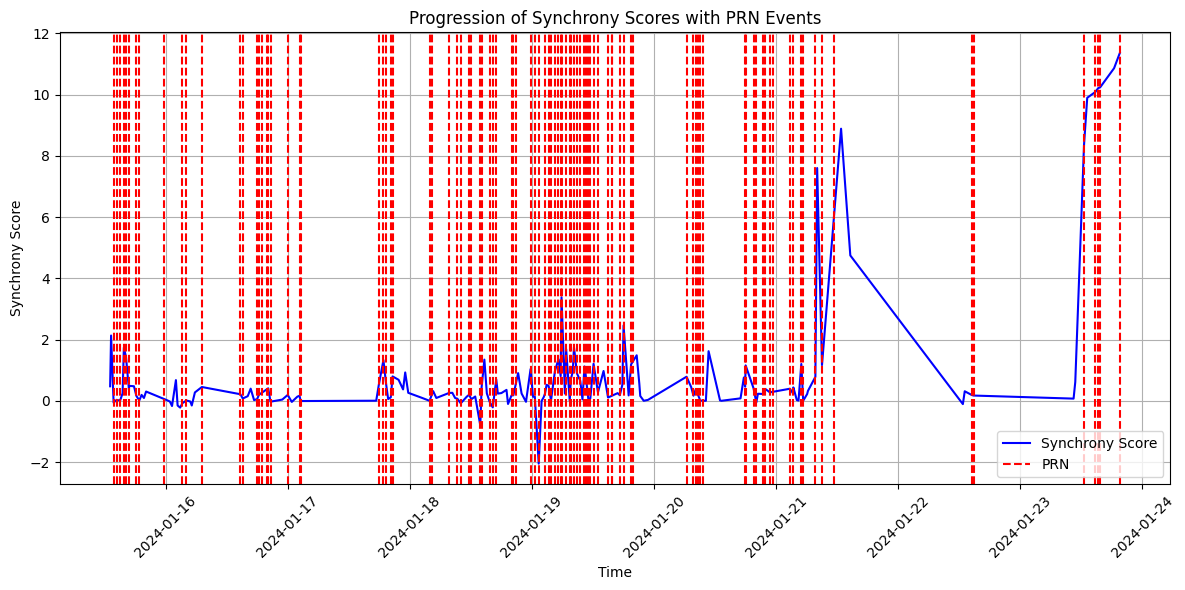

Processing Patient4
Loading Ventilator data
Skipping SBS score -1 at time 2023-11-14 03:20:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2023-11-14 08:16:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-14 10:47:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-14 13:14:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-15 11:59:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-15 05:15:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-15 12:14:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2023-11-16 06:16:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2023-11-16 07:16:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2023-11-16 08:46:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-11-16 11:16:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2023-1

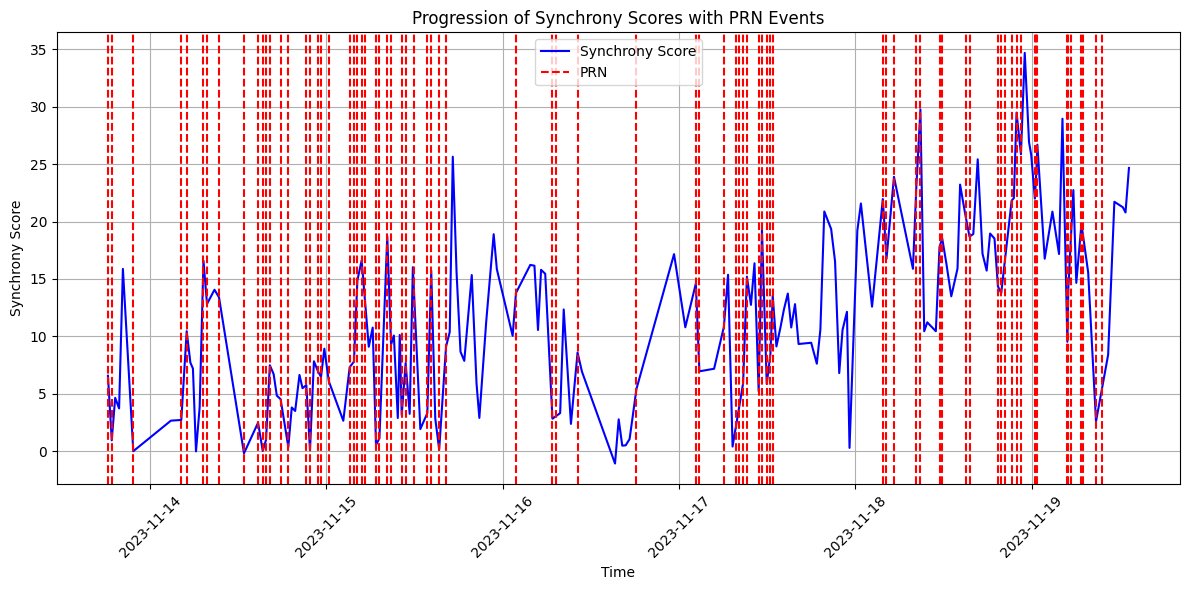

Processing Patient11
Loading Ventilator data
Skipping SBS score -2 at time 2024-01-22 14:29:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-22 15:12:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 15:38:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 16:02:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2024-01-23 10:01:00 due to zero mean respiratory rate
Skipping SBS score 0 at time 2024-01-23 12:33:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-23 14:39:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 07:24:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 13:26:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 13:52:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 2024-01-24 14:25:00 due to zero mean respiratory rate
Skipping SBS score -2 at time 202

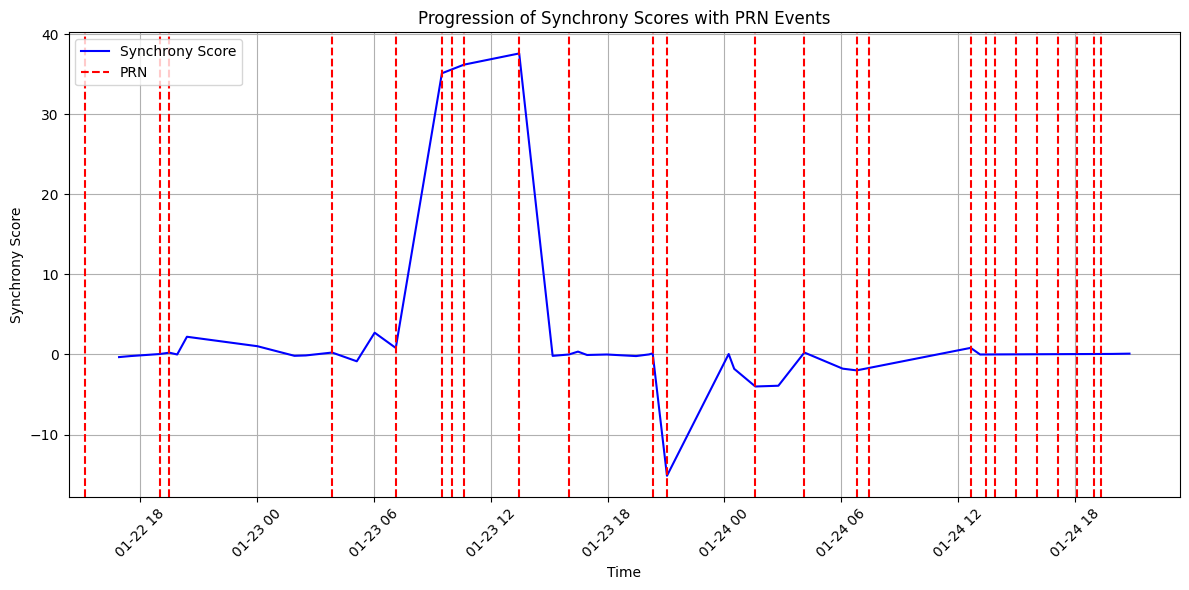

: 

In [38]:
for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        print(f'Processing {patient}')          
        data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_Retro.mat')
        
        data = loadmat(data_filepath)
        SBS = data['sbs'].flatten()
        rr = data['respiratory_rate']
        sbs_time = data['start_time']
        sbs_time = pd.to_datetime(sbs_time, errors='coerce')
        retro_PRN = data['PRNs'].flatten()
        # Remove all white spaces from each string
        retro_PRN = [s.replace(" ", "") for s in retro_PRN]
        
        ventilator_file = os.path.join(patient_dir, f'{patient}_ventilator_data.xlsx')
        print('Loading Ventilator data')

        if not os.path.isfile(ventilator_file):
            print("Ventilator File not found")
            continue 

        ventilator_data, vent_features = load_from_excel(ventilator_file)
        set_rate_data = ventilator_data[ventilator_data['meas_disp_name'] == 'Set Rate (bpm)'].copy()
        set_rate_data['assessment_datetime'] = pd.to_datetime(set_rate_data['assessment_datetime'], format='%Y-%m-%d %H:%M:%S')
        set_rate_data = set_rate_data.sort_values('assessment_datetime', ascending=True)
        
        # Calculate synchrony scores
        sync_data = []
        for i, (score, time) in enumerate(zip(SBS, sbs_time)):
            mean_rr = rr[i].mean()

            # Skip iteration if mean_rr = 0
            if mean_rr == 0:
                print(f"Skipping SBS score {score} at time {time} due to zero mean respiratory rate")
                continue
            
            # Initialize set_rate to None
            set_rate = None
            
            mask = set_rate_data['assessment_datetime'] <= time

            # Check if any rows match the condition
            if mask.any():
                # Get the most recent set rate
                set_rate = set_rate_data[mask]['question_response'].iloc[-1]
                # print(f"Set rate found: {set_rate}")

                set_rate_time = set_rate_data[mask]['assessment_datetime'].iloc[-1]
            else:
                set_rate = None
                print("No matching set rate found")
            
            # If a set_rate was found, calculate and append the synchrony score
            if set_rate is not None:
                sync_data.append({
                    'SBS': score,
                    'mean_rr': mean_rr,
                    'set_rate': set_rate,
                    'Synchrony_Score': mean_rr - set_rate,
                    'Vent_time': set_rate_time,
                    'Time': time
                })
        print(sync_data)
        print(f"Final sync_data length: {len(sync_data)}")

        df = pd.DataFrame(sync_data)

        # Convert 'Time' column to datetime if it's not already
        df['Time'] = pd.to_datetime(df['Time'])

        # Sort the DataFrame by time
        df = df.sort_values('Time')

        # Create the plot
        plt.figure(figsize=(12, 6))

        # Plot the Synchrony Score
        plt.plot(df['Time'], df['Synchrony_Score'], label='Synchrony Score', color='b')

        # Draw vertical lines for PRN events
        for i, prn in enumerate(retro_PRN):
            if prn == "Y":
                plt.axvline(x=sbs_time[i], color='r', linestyle='--', label='PRN' if i == retro_PRN.index("Y") else "")

        # Customize the plot
        plt.xlabel('Time')
        plt.ylabel('Synchrony Score')
        plt.title('Progression of Synchrony Scores with PRN Events')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)

        # Show the plot
        plt.tight_layout()
        plt.show()





